In [20]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [21]:
config = load_config()
od = '../snakemake/compare_external/'

In [22]:
df = pd.DataFrame()
ics = [od+config['gtex']['cerb']['ics'],
       od+config['chess']['cerb']['ics'],
       od+config['enc']['cerb']['ics'],
       od+config['lr']['cerb']['ics'],
       od+config['ref']['cerb']['ics']]
sources = ['gtex', 'chess', 'enc', 'us', 'v47']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    

In [23]:
temp = df.copy(deep=True)

In [24]:
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
# df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
df.head()
df.reset_index(drop=True, inplace=True)

In [25]:
df.loc[(df.chess==True)&(df.gtex==True)].Coordinates.tolist()[0]


'100015726-100019230-100019349-100023418-100023932-100024153-100024307-100029860-100029952-100030248-100030375-100033304'

In [26]:
temp.loc[temp.Coordinates=='100015726-100019230-100019349-100023418-100023932-100024153-100024307-100029860-100029952-100030248-100030375-100033304']

,Chromosome,Strand,Coordinates,source
81964,chr7,+,100015726-100019230-100019349-100023418-100023...,gtex
122967,chr7,+,100015726-100019230-100019349-100023418-100023...,chess


In [27]:
df.head()

source,Strand,Coordinates,Chromosome,chess,enc,gtex,us,v47
0,+,100000063-100008120-100008322-100011375,chr7,False,False,False,False,True
1,+,100006296-100007901-100008231-100037527,chr4,False,False,False,False,True
2,+,1000064-1000611-1000697-1000881-1000989-100146...,chr4,True,False,False,True,True
3,+,100008231-100024938-100025080-100025281-100025...,chr4,False,False,False,False,True
4,+,100015726-100019230-100019349-100023418-100023...,chr7,True,True,False,False,True


In [28]:
# df['id'] = df.Strand+'_'+df.Chromosome+'_'+df.Coordinates
# df.drop(['Strand', 'Chromosome', 'Coordinates'], axis=1, inplace=True)
# df = df.groupby(['chess', 'gtex']).count().rename({'id':'n_ics'}, axis=1)

In [29]:
df.set_index(['chess', 'gtex', 'enc', 'us', 'v47'], inplace=True)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

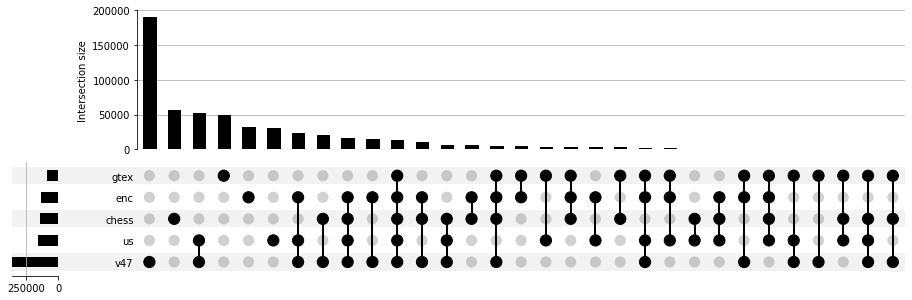

In [30]:
upsetplot.plot(df, sort_by='cardinality')


In [31]:
df.head()

source                       Strand  \
chess gtex  enc   us    v47           
False False False False True      +   
                        True      +   
True  False False True  True      +   
False False False False True      +   
True  False True  False True      +   

source                                                              Coordinates  \
chess gtex  enc   us    v47                                                       
False False False False True            100000063-100008120-100008322-100011375   
                        True            100006296-100007901-100008231-100037527   
True  False False True  True  1000064-1000611-1000697-1000881-1000989-100146...   
False False False False True  100008231-100024938-100025080-100025281-100025...   
True  False True  False True  100015726-100019230-100019349-100023418-100023...   

source                       Chromosome  
chess gtex  enc   us    v47              
False False False False True       chr7  
                        True       chr4  
True  False False True  True       chr4  
False False False False True       chr4  
True  False True  False True       chr7